# From GettingDataReady to EDA

Based on work by [Chris Beaumont](http://chrisbeaumont.org) for cs109.

![](images/tom-hanks-castaway-fire.jpg)

*This scene from Cast Away is an accurate metaphor for the amount of time you'll spend cleaning data, and the delirium you'll experience at the end.*

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Here's a preview of the raw data we'll use -- it's a list of the 10,000 movies made since 1950 with the most IMDB user ratings. It was scraped in 2012 from [pages like this](http://www.imdb.com/search/title?sort=num_votes,desc&title_type=feature&year=1950,2012). 

In [2]:
!head data/imdb_top_10000.txt

tt0111161	The Shawshank Redemption (1994)	1994	 9.2	619479	142 mins.	Crime|Drama
tt0110912	Pulp Fiction (1994)	1994	 9.0	490065	154 mins.	Crime|Thriller
tt0137523	Fight Club (1999)	1999	 8.8	458173	139 mins.	Drama|Mystery|Thriller
tt0133093	The Matrix (1999)	1999	 8.7	448114	136 mins.	Action|Adventure|Sci-Fi
tt1375666	Inception (2010)	2010	 8.9	385149	148 mins.	Action|Adventure|Sci-Fi|Thriller
tt0109830	Forrest Gump (1994)	1994	 8.7	368994	142 mins.	Comedy|Drama|Romance
tt0169547	American Beauty (1999)	1999	 8.6	338332	122 mins.	Drama
tt0499549	Avatar (2009)	2009	 8.1	336855	162 mins.	Action|Adventure|Fantasy|Sci-Fi
tt0108052	Schindler's List (1993)	1993	 8.9	325888	195 mins.	Biography|Drama|History|War
tt0080684	Star Wars: Episode V - The Empire Strikes Back (1980)	1980	 8.8	320105	124 mins.	Action|Adventure|Family|Sci-Fi


## 1. Build a DataFrame

The textfile is tab-separated, and doesn't have any column headers. We
set the appropriate keywords in `pd.read_csv` to handle this

In [3]:
names = ['imdbID', 'title', 'year', 'score', 'votes', 'runtime', 'genres']
data = pd.read_csv('data/imdb_top_10000.txt', delimiter='\t', names=names)
print("Number of rows: %i" % data.shape[0])
data.head()  # print the first 5 rows

Number of rows: 10000


,imdbID,title,year,score,votes,runtime,genres
0,tt0111161,The Shawshank Redemption (1994),1994,9.2,619479,142 mins.,Crime|Drama
1,tt0110912,Pulp Fiction (1994),1994,9.0,490065,154 mins.,Crime|Thriller
2,tt0137523,Fight Club (1999),1999,8.8,458173,139 mins.,Drama|Mystery|Thriller
3,tt0133093,The Matrix (1999),1999,8.7,448114,136 mins.,Action|Adventure|Sci-Fi
4,tt1375666,Inception (2010),2010,8.9,385149,148 mins.,Action|Adventure|Sci-Fi|Thriller


If you dont have a key to the data you should produce one...here I write it as a dict, but you might find it easier to whip up google sheets/excel and produce this. The idea is to store a key CSV.

In [4]:
datakeydict = dict(
    imdbID = "A unique identifier for the movie in the imdb system",
    title = "The name of the movie",
    year = "The year in which the movie was released",
    score = "The score on a scale of 1-10 given my IMDB users",
    votes = "The number of votes this movie recieved on IMDB",
    runtime = "How long the movie runs, in minutes",
    genres = "A pipe(|) separated list of genres for the movie"
)
datakey = pd.DataFrame(datakeydict.items(), columns=['Column', 'Description'])
datakey

,Column,Description
0,imdbID,A unique identifier for the movie in the imdb ...
1,title,The name of the movie
2,year,The year in which the movie was released
3,score,The score on a scale of 1-10 given my IMDB users
4,votes,The number of votes this movie recieved on IMDB
5,runtime,"How long the movie runs, in minutes"
6,genres,A pipe(|) separated list of genres for the movie


In [5]:
datakey.to_csv("processed_data/imdb_top_10000.key.txt", index=False)

## 2. The Check-Transform/Clean-Check cycle

In [6]:
data.dtypes

imdbID      object
title       object
year         int64
score      float64
votes        int64
runtime     object
genres      object
dtype: object

Notice that the `runtime` should be a number, the movie runtime in minutes. Looking at types can help us enormously in cleaning.

Lets see which columns have missing data:

In [7]:
for cname in names:
    print(cname, data[cname].isnull().sum())

imdbID 0
title 0
year 0
score 0
votes 0
runtime 0
genres 1


We can handle testing for  issues by writing a table report function:

In [8]:
from IPython.display import display, HTML

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='NA'
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)

In [9]:
tbl_report(data)

Table Shape (10000, 7)


,dtype,nulls,uniques,num_uniques,value_counts
imdbID,object,0,"[tt0111161, tt0110912, tt0137523, tt0133093, tt1375666, tt0109830, tt0169547, tt0499549, tt0108052, tt0080684, tt0372784, tt0114814, tt0102926, tt0120338, tt0112573, tt0167404, tt0266697, tt0099685, tt0416449, tt0482571, tt0105236, tt0110413, tt0120689, tt0361748, tt0910970, tt0468569, tt0068646, tt0120737, tt0167260, tt0167261, tt0076759, tt0114369, tt0172495, tt0209144, tt0120815, tt0407887, tt0401792, tt0071562, tt0325980, tt0103064, tt0082971, tt0434409, tt0120586, tt0338013, tt0073486, tt0246578, tt0088763, tt0086190, tt0477348, tt0418279, tt0066921, tt1010048, tt0211915, tt0095016, tt0088247, tt0083658, tt0208092, tt0266543, tt0317248, tt1136608, tt0114746, tt0381061, tt0090605, tt0317705, tt0114709, tt0119488, tt0457430, tt0126029, tt1119646, tt0480249, tt0093058, tt0440963, tt0107290, tt0071853, tt0110357, tt0180093, tt0378194, tt0120915, tt0081505, tt0118715, tt0078748, tt0371746, tt0121766, tt0078788, tt0097576, tt0060196, tt0375679, tt0120382, tt0145487, tt0116282, tt0075314, tt0206634, tt0062622, tt0086250, tt0119217, tt0383574, tt0121765, tt0117951, tt0057012, tt0467406, ...]",10000,NA
title,object,0,"[The Shawshank Redemption (1994), Pulp Fiction (1994), Fight Club (1999), The Matrix (1999), Inception (2010), Forrest Gump (1994), American Beauty (1999), Avatar (2009), Schindler's List (1993), Star Wars: Episode V - The Empire Strikes Back (1980), Batman Begins (2005), The Usual Suspects (1995), The Silence of the Lambs (1991), Titanic (1997), Braveheart (1995), The Sixth Sense (1999), Kill Bill: Vol. 1 (2003), Goodfellas (1990), 300 (2006), The Prestige (2006), Reservoir Dogs (1992), Leon: The Professional (1994), The Green Mile (1999), Inglourious Basterds (2009), WALL\xb7E (2008), The Dark Knight (2008), The Godfather (1972), The Lord of the Rings: The Fellowship of the Ring (2001), The Lord of the Rings: The Return of the King (2003), The Lord of the Rings: The Two Towers (2002), Star Wars: Episode IV - A New Hope (1977), Se7en (1995), Gladiator (2000), Memento (2000), Saving Private Ryan (1998), The Departed (2006), Sin City (2005), The Godfather: Part II (1974), Pirates of the Caribbean: The Curse of the Black Pearl (2003), Terminator 2: Judgment Day (1991), Raiders of the Lost Ark (1981), V for Vendetta (2006), American History X (1998), Eternal Sunshine of the Spotless Mind (2004), One Flew Over the Cuckoo's Nest (1975), Donnie Darko (2001), Back to the Future (1985), Star Wars: Episode VI - Return of the Jedi (1983), No Country for Old Men (2007), Transformers (2007), A Clockwork Orange (1971), Slumdog Millionaire (2008), Am\xe9lie (2001), Die Hard (1988), The Terminator (1984), Blade Runner (1982), Snatch. (2000), Finding Nemo (2003), City of God (2002), District 9 (2009), Twelve Monkeys (1995), Casino Royale (2006), Aliens (1986), The Incredibles (2004), Toy Story (1995), L.A. Confidential (1997), Pan's Labyrinth (2006), Shrek (2001), The Hangover (2009), I Am Legend (2007), Full Metal Jacket (1987), The Bourne Ultimatum (2007), Jurassic Park (1993), Monty Python and the Holy Grail (1975), The Lion King (1994), Requiem for a Dream (2000), Kill Bill: Vol. 2 (2004), Star Wars: Episode I - The Phantom Menace (1999), The Shining (1980), The Big Lebowski (1998), Alien (1979), Iron Man (2008), Star Wars: Episode III - Revenge of the Sith (2005), Apocalypse Now (1979), Indiana Jones and the Last Crusade (1989), The Good, the Bad and the Ugly (1966), Crash (2004), The Truman Show (1998), Spider-Man (2002), Fargo (1996), Taxi Driver (1976), Children of Men (2006), 2001: A Space Odyssey (1968), Scarface (1983), Good Will Hunting (1997), Pirates of the Caribbean: Dead Man's Chest (2006), Star Wars: Episode II - Attack of the Clones (2002), Trainspotting (1996), Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964), Juno (2007), ...]",9998,NA
year,int64,0,"[1994, 1999, 2010, 2009, 1993, 1980, 2005, 1995, 1991, 1997, 2003, 1990, 200

There are several problems with the DataFrame at this point:

1. The runtime column describes a number, but is stored as a string
2. The genres column is not atomic -- it aggregates several genres together. This makes it hard, for example, to extract which movies are Comedies. Also there is one row for which the genre is null
3. The movie year is repeated in the title and year column: repetition is bad!

### Handling the `null` in the genres

In [10]:
data[data.genres.isnull()]

,imdbID,title,year,score,votes,runtime,genres
7917,tt0990404,Chop Shop (2007),2007,7.2,2104,84 mins.,NaN


Why is the genres column a null for Chop Shop? Lets look in the file:

In [11]:
!grep 'Chop Shop' data/imdb_top_10000.txt

tt0990404	Chop Shop (2007)	2007	 7.2	2104	84 mins.	


It is because no genres were recorded for it. At this point we have some choices. We can

1. Remove it from the data set
2. Let it be without genres and handle in further post-processing
3. Perhaps this was a mistake in scraping and we can go to the IMDB page for more information

Here we will opt for choice 2 and leave the null in our data set.

In general, `null` in columns can come from multiple places. Firstly, that data may not have been taken in some cases. If this is a fatal error for us, we must remove those rows.

If the lack of information there is an important signal, we leave the null in there and treat it as a category.

Otherwise we can impute this value from the median value of the column (or in other ways) and make a note in an accompanying column that we made an imputation. We'll see this strategy later, when we develop a general strategy for handling missing values.

### Fixing the runtime column

The following snipptet converts a string like '142 mins.' to the number 142:

In [12]:
dirty = '142 mins.'
number, text = dirty.split(' ')
clean = int(number)
number, clean

('142', 142)

We can package this up into a list comprehension

In [13]:
clean_runtime = [float(r.split(' ')[0]) for r in data.runtime]
data['runtime'] = clean_runtime
data.head()

,imdbID,title,year,score,votes,runtime,genres
0,tt0111161,The Shawshank Redemption (1994),1994,9.2,619479,142.0,Crime|Drama
1,tt0110912,Pulp Fiction (1994),1994,9.0,490065,154.0,Crime|Thriller
2,tt0137523,Fight Club (1999),1999,8.8,458173,139.0,Drama|Mystery|Thriller
3,tt0133093,The Matrix (1999),1999,8.7,448114,136.0,Action|Adventure|Sci-Fi
4,tt1375666,Inception (2010),2010,8.9,385149,148.0,Action|Adventure|Sci-Fi|Thriller


Now the `runtime` column if fixed.

In [14]:
data.dtypes

imdbID      object
title       object
year         int64
score      float64
votes        int64
runtime    float64
genres      object
dtype: object

### Removing year from the title
We can fix each element by stripping off the last 7 characters

In [15]:
data['title'] = [t[0:-7] for t in data.title]
data.head()

,imdbID,title,year,score,votes,runtime,genres
0,tt0111161,The Shawshank Redemption,1994,9.2,619479,142.0,Crime|Drama
1,tt0110912,Pulp Fiction,1994,9.0,490065,154.0,Crime|Thriller
2,tt0137523,Fight Club,1999,8.8,458173,139.0,Drama|Mystery|Thriller
3,tt0133093,The Matrix,1999,8.7,448114,136.0,Action|Adventure|Sci-Fi
4,tt1375666,Inception,2010,8.9,385149,148.0,Action|Adventure|Sci-Fi|Thriller


### Splitting up the genres: Multi-Categorization

We can use the concept of *indicator variables* to split the genres column into many columns. Each new column will correspond to a single genre, and each cell will be True or False.

In [16]:
#determine the unique genres
import types
genres = set()
notnulls = pd.notnull(data.genres)
for m, nn in zip(data.genres, notnulls):
    if nn: # not a NaN
        genres.update(g for g in m.split('|'))
    # Otherwise empty: see Chop Shop
genres = sorted(genres)

#make a column for each genre
for genre in genres:
    data['genre:'+genre] = [genre in movie.split('|') if nn else False for movie, nn in zip(data.genres, notnulls)]
         
data.head()

,imdbID,title,year,score,votes,runtime,genres,genre:Action,genre:Adult,genre:Adventure,...,genre:Musical,genre:Mystery,genre:News,genre:Reality-TV,genre:Romance,genre:Sci-Fi,genre:Sport,genre:Thriller,genre:War,genre:Western
0,tt0111161,The Shawshank Redemption,1994,9.2,619479,142.0,Crime|Drama,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,tt0110912,Pulp Fiction,1994,9.0,490065,154.0,Crime|Thriller,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,tt0137523,Fight Club,1999,8.8,458173,139.0,Drama|Mystery|Thriller,False,False,False,...,False,True,False,False,False,False,False,True,False,False
3,tt0133093,The Matrix,1999,8.7,448114,136.0,Action|Adventure|Sci-Fi,True,False,True,...,False,False,False,False,False,True,False,False,False,False
4,tt1375666,Inception,2010,8.9,385149,148.0,Action|Adventure|Sci-Fi|Thriller,True,False,True,...,False,False,False,False,False,True,False,True,False,False


In [17]:
data[data.title=='Chop Shop']

,imdbID,title,year,score,votes,runtime,genres,genre:Action,genre:Adult,genre:Adventure,...,genre:Musical,genre:Mystery,genre:News,genre:Reality-TV,genre:Romance,genre:Sci-Fi,genre:Sport,genre:Thriller,genre:War,genre:Western
7917,tt0990404,Chop Shop,2007,7.2,2104,84.0,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
data.dtypes

imdbID               object
title                object
year                  int64
score               float64
votes                 int64
runtime             float64
genres               object
genre:Action           bool
genre:Adult            bool
genre:Adventure        bool
genre:Animation        bool
genre:Biography        bool
genre:Comedy           bool
genre:Crime            bool
genre:Drama            bool
genre:Family           bool
genre:Fantasy          bool
genre:Film-Noir        bool
genre:History          bool
genre:Horror           bool
genre:Music            bool
genre:Musical          bool
genre:Mystery          bool
genre:News             bool
genre:Reality-TV       bool
genre:Romance          bool
genre:Sci-Fi           bool
genre:Sport            bool
genre:Thriller         bool
genre:War              bool
genre:Western          bool
dtype: object

Let us save the dataframe to disk before we go doing EDA on it!

In [19]:
data.to_csv("processed_data/imdb_top_10000_cleaned.csv", index=False)

In [20]:
!head -5 processed_data/imdb_top_10000_cleaned.csv

imdbID,title,year,score,votes,runtime,genres,genre:Action,genre:Adult,genre:Adventure,genre:Animation,genre:Biography,genre:Comedy,genre:Crime,genre:Drama,genre:Family,genre:Fantasy,genre:Film-Noir,genre:History,genre:Horror,genre:Music,genre:Musical,genre:Mystery,genre:News,genre:Reality-TV,genre:Romance,genre:Sci-Fi,genre:Sport,genre:Thriller,genre:War,genre:Western
tt0111161,The Shawshank Redemption,1994,9.2,619479,142.0,Crime|Drama,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0110912,Pulp Fiction,1994,9.0,490065,154.0,Crime|Thriller,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
tt0137523,Fight Club,1999,8.8,458173,139.0,Drama|Mystery|Thriller,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
tt0133093

Lets see how our rubric extends to EDA. You have seen (1) and (2) before. Now let us see (3) and (4).

The basic workflow is as follows:

1. **Build** a DataFrame from the data (ideally, put *all* data in this object)
2. **Clean** the DataFrame. It should have the following properties:
   * Each row describes a single object
   * Each column describes a property of that object
   * Columns are numeric whenever appropriate
   * Columns contain atomic properties that cannot be further decomposed
3. Explore **global properties**. Use histograms, scatter plots, and aggregation functions to summarize the data.
4. Explore **group properties**. Use groupby and faceting and small multiples to compare subsets of the data.

This process transforms your data into a format which is easier to work with, gives you a basic overview of 
the data's properties, and likely generates several questions for you to followup in subsequent analysis.

## 3. Explore global properties

Next, we get a handle on some basic, global summaries of the DataFrame.

### Call `describe` on relevant columns

In [26]:
data = pd.read_csv("processed_data/imdb_top_10000_cleaned.csv")
data.head()

,imdbID,title,year,score,votes,runtime,genres,genre:Action,genre:Adult,genre:Adventure,...,genre:Musical,genre:Mystery,genre:News,genre:Reality-TV,genre:Romance,genre:Sci-Fi,genre:Sport,genre:Thriller,genre:War,genre:Western
0,tt0111161,The Shawshank Redemption,1994,9.2,619479,142.0,Crime|Drama,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,tt0110912,Pulp Fiction,1994,9.0,490065,154.0,Crime|Thriller,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,tt0137523,Fight Club,1999,8.8,458173,139.0,Drama|Mystery|Thriller,False,False,False,...,False,True,False,False,False,False,False,True,False,False
3,tt0133093,The Matrix,1999,8.7,448114,136.0,Action|Adventure|Sci-Fi,True,False,True,...,False,False,False,False,False,True,False,False,False,False
4,tt1375666,Inception,2010,8.9,385149,148.0,Action|Adventure|Sci-Fi|Thriller,True,False,True,...,False,False,False,False,False,True,False,True,False,False


In [27]:
tbl_report(data)

Table Shape (10000, 31)


,dtype,nulls,uniques,num_uniques,value_counts
imdbID,object,0,"[tt0111161, tt0110912, tt0137523, tt0133093, tt1375666, tt0109830, tt0169547, tt0499549, tt0108052, tt0080684, tt0372784, tt0114814, tt0102926, tt0120338, tt0112573, tt0167404, tt0266697, tt0099685, tt0416449, tt0482571, tt0105236, tt0110413, tt0120689, tt0361748, tt0910970, tt0468569, tt0068646, tt0120737, tt0167260, tt0167261, tt0076759, tt0114369, tt0172495, tt0209144, tt0120815, tt0407887, tt0401792, tt0071562, tt0325980, tt0103064, tt0082971, tt0434409, tt0120586, tt0338013, tt0073486, tt0246578, tt0088763, tt0086190, tt0477348, tt0418279, tt0066921, tt1010048, tt0211915, tt0095016, tt0088247, tt0083658, tt0208092, tt0266543, tt0317248, tt1136608, tt0114746, tt0381061, tt0090605, tt0317705, tt0114709, tt0119488, tt0457430, tt0126029, tt1119646, tt0480249, tt0093058, tt0440963, tt0107290, tt0071853, tt0110357, tt0180093, tt0378194, tt0120915, tt0081505, tt0118715, tt0078748, tt0371746, tt0121766, tt0078788, tt0097576, tt0060196, tt0375679, tt0120382, tt0145487, tt0116282, tt0075314, tt0206634, tt0062622, tt0086250, tt0119217, tt0383574, tt0121765, tt0117951, tt0057012, tt0467406, ...]",10000,NA
title,object,0,"[The Shawshank Redemption, Pulp Fiction, Fight Club, The Matrix, Inception, Forrest Gump, American Beauty, Avatar, Schindler's List, Star Wars: Episode V - The Empire Strikes Back, Batman Begins, The Usual Suspects, The Silence of the Lambs, Titanic, Braveheart, The Sixth Sense, Kill Bill: Vol. 1, Goodfellas, 300, The Prestige, Reservoir Dogs, Leon: The Professional, The Green Mile, Inglourious Basterds, WALL\xb7E, The Dark Knight, The Godfather, The Lord of the Rings: The Fellowship of the Ring, The Lord of the Rings: The Return of the King, The Lord of the Rings: The Two Towers, Star Wars: Episode IV - A New Hope, Se7en, Gladiator, Memento, Saving Private Ryan, The Departed, Sin City, The Godfather: Part II, Pirates of the Caribbean: The Curse of the Black Pearl, Terminator 2: Judgment Day, Raiders of the Lost Ark, V for Vendetta, American History X, Eternal Sunshine of the Spotless Mind, One Flew Over the Cuckoo's Nest, Donnie Darko, Back to the Future, Star Wars: Episode VI - Return of the Jedi, No Country for Old Men, Transformers, A Clockwork Orange, Slumdog Millionaire, Am\xe9lie, Die Hard, The Terminator, Blade Runner, Snatch., Finding Nemo, City of God, District 9, Twelve Monkeys, Casino Royale, Aliens, The Incredibles, Toy Story, L.A. Confidential, Pan's Labyrinth, Shrek, The Hangover, I Am Legend, Full Metal Jacket, The Bourne Ultimatum, Jurassic Park, Monty Python and the Holy Grail, The Lion King, Requiem for a Dream, Kill Bill: Vol. 2, Star Wars: Episode I - The Phantom Menace, The Shining, The Big Lebowski, Alien, Iron Man, Star Wars: Episode III - Revenge of the Sith, Apocalypse Now, Indiana Jones and the Last Crusade, The Good, the Bad and the Ugly, Crash, The Truman Show, Spider-Man, Fargo, Taxi Driver, Children of Men, 2001: A Space Odyssey, Scarface, Good Will Hunting, Pirates of the Caribbean: Dead Man's Chest, Star Wars: Episode II - Attack of the Clones, Trainspotting, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Juno, ...]",9739,NA
year,int64,0,"[1994, 1999, 2010, 2009, 1993, 1980, 2005, 1995, 1991, 1997, 2003, 1990, 2006, 1992, 2008, 1972, 2001, 2002, 1977, 2000, 1998, 1974, 1981, 2004, 1975, 1985, 1983, 2007, 1971, 1988, 1984, 1982, 1986, 1987, 1979, 1989, 1966, 1996, 1976, 1968, 1964, 1960, 1957, 1954, 1973, 1959, 1958, 1978, 1962, 1967, 2011, 1963, 1969, 1950, 1952, 1965, 1970, 1961, 1951, 1953, 1956, 1955]",62,NA
score,float64,0,"[9.2, 9.0, 8.8, 8.7, 8.9, 8.6, 8.1, 8.3, 7.4, 8.4, 8.2, 7.8, 8.5, 8.0, 7.2, 7.9, 7.1, 6.4, 7.3, 6.8, 6.6, 7.7, 6.5, 7.5, 7.6, 7.0, 5.4, 6.2, 5.9, 6.9, 5.5, 6.3, 5.8, 6.7, 6.1, 4.5, 3.5, 5.7, 5.1, 5.6, 6.0, 5.2, 4.9, 4.3, 4.7, 2.2, 2.5, 5.3, 4.8, 5.0, 2.4, 3.2, 1.7, 4.6, 2.6, 3.4, 4.0, 4.2, 3.6, 3.3, 2.3, 3.7, 4.4, 3.8, 1.8, 2.9, 2.0, 3.9, 4.1, 2.7, 1.5, 2.8, 3.1, 3.0, 1.6, 2.1

In [28]:
data[['score', 'runtime', 'year', 'votes']].describe()

,score,runtime,year,votes
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,6.386070,103.578400,1993.472800,16604.012800
std,1.189933,26.628698,14.829924,34563.459698
min,1.500000,0.000000,1950.000000,1356.000000
25%,5.700000,93.000000,1986.000000,2333.750000
50%,6.600000,102.000000,1998.000000,4980.500000
75%,7.200000,115.000000,2005.000000,15277.750000
max,9.200000,450.000000,2011.000000,619479.000000


In [31]:
#hmmm, a runtime of 0 looks suspicious. How many movies have that?
print(len(data[data.runtime == 0]))

#probably best to flag those bad data as NAN
data['runtime'][data.runtime==0] = np.nan

0


<ipython-input-31-112aa0073759>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['runtime'][data.runtime==0] = np.nan


After flagging bad runtimes, we repeat

In [32]:
data.runtime.describe()

count    9718.000000
mean      106.584071
std        20.230586
min        45.000000
25%        93.000000
50%       103.000000
75%       115.000000
max       450.000000
Name: runtime, dtype: float64

### Make some basic plots

Text(0.5, 0, 'Release Year')

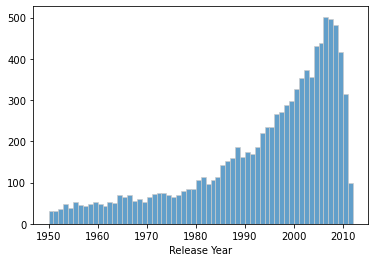

In [48]:
# more movies in recent years, but not *very* recent movies (they haven't had time to receive lots of votes yet?)
plt.hist(data.year, bins=np.arange(1950, 2013), alpha=0.7, lw=1, edgecolor='#cccccc')
plt.xlabel("Release Year")

Text(0.5, 0, 'IMDB rating')

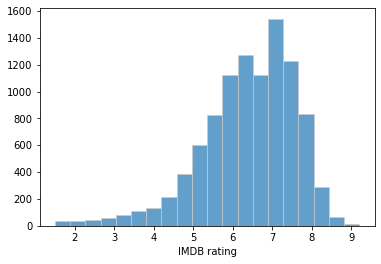

In [51]:
plt.hist(data.score, bins=20, alpha=0.7, edgecolor='#cccccc')
plt.xlabel("IMDB rating")

Text(0.5, 0, 'Runtime distribution')

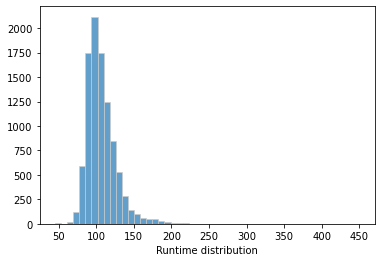

In [55]:
plt.hist(data.runtime.dropna(), bins=50, alpha=0.7, edgecolor='#cccccc')
plt.xlabel("Runtime distribution")

Text(0.5, 0, 'Runtime distribution')

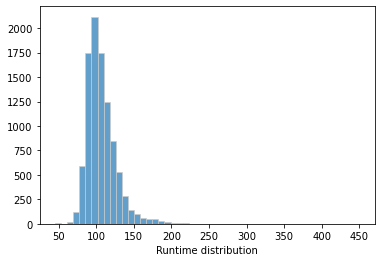

In [57]:
plt.hist(data.runtime, bins=50, alpha=0.7, edgecolor='#cccccc')
plt.xlabel("Runtime distribution")

Text(0, 0.5, 'IMDB Rating')

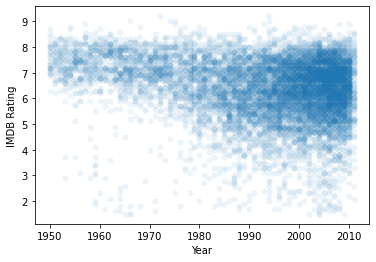

In [65]:
#hmm, more bad, recent movies. Real, or a selection bias?

plt.scatter(data.year, data.score, lw=0, alpha=.08)
plt.xlabel("Year")
plt.ylabel("IMDB Rating")

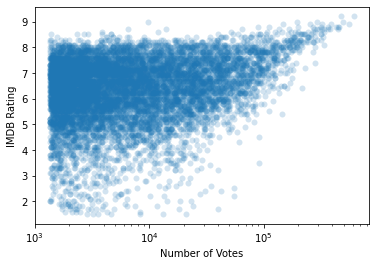

In [68]:
plt.scatter(data.votes, data.score, lw=0, alpha=.2)
plt.xlabel("Number of Votes")
plt.ylabel("IMDB Rating")
plt.xscale('log')


### Identify some outliers

In [69]:
# low-score movies with lots of votes
data[(data.votes > 9e4) & (data.score < 5)][['title', 'year', 'score', 'votes', 'genres']]

,title,year,score,votes,genres
317,New Moon,2009,4.5,90457,Adventure|Drama|Fantasy|Romance
334,Batman & Robin,1997,3.5,91875,Action|Crime|Fantasy|Sci-Fi


In [70]:
# The lowest rated movies
data[data.score == data.score.min()][['title', 'year', 'score', 'votes', 'genres']]

,title,year,score,votes,genres
1982,Manos: The Hands of Fate,1966,1.5,20927,Horror
2793,Superbabies: Baby Geniuses 2,2004,1.5,13196,Comedy|Family
3746,Daniel the Wizard,2004,1.5,8271,Comedy|Crime|Family|Fantasy|Horror
5158,Ben & Arthur,2002,1.5,4675,Drama|Romance
5993,Night Train to Mundo Fine,1966,1.5,3542,Action|Adventure|Crime|War
6257,Monster a-Go Go,1965,1.5,3255,Sci-Fi|Horror
6726,Dream Well,2009,1.5,2848,Comedy|Romance|Sport


In [71]:
# The highest rated movies
data[data.score == data.score.max()][['title', 'year', 'score', 'votes', 'genres']]

,title,year,score,votes,genres
0,The Shawshank Redemption,1994,9.2,619479,Crime|Drama
26,The Godfather,1972,9.2,474189,Crime|Drama


### Run aggregation functions like `sum` over several rows or columns

*What genres are the most frequent?*

In [78]:
genre_cols = ['genre:'+g for g in genres]
#sum sums over rows by default
genre_count = data[genre_cols].sum().sort_values(ascending=False)
genre_count

genre:Drama         5697
genre:Comedy        3922
genre:Thriller      2832
genre:Romance       2441
genre:Action        1891
genre:Crime         1867
genre:Adventure     1313
genre:Horror        1215
genre:Mystery       1009
genre:Fantasy        916
genre:Sci-Fi         897
genre:Family         754
genre:War            512
genre:Biography      394
genre:Music          371
genre:History        358
genre:Animation      314
genre:Sport          288
genre:Musical        260
genre:Western        235
genre:Film-Noir       40
genre:Adult            9
genre:News             1
genre:Reality-TV       1
dtype: int64

*How many genres does a movie have, on average?*

In [80]:
#axis=1 sums over columns instead
genre_count = data[genre_cols].sum(axis=1) 
print("Average movie has %0.2f genres" % genre_count.mean())
genre_count.describe()

Average movie has 2.75 genres


count    10000.000000
mean         2.753700
std          1.169176
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          8.000000
dtype: float64

## 4. Explore Group Properties

Let's split up movies by decade

In [83]:
decade =  (data.year // 10) * 10

tyd = data[['title', 'year']].copy()
tyd['decade'] = decade

tyd.head()

,title,year,decade
0,The Shawshank Redemption,1994,1990
1,Pulp Fiction,1994,1990
2,Fight Club,1999,1990
3,The Matrix,1999,1990
4,Inception,2010,2010


[GroupBy](http://pandas.pydata.org/pandas-docs/dev/groupby.html) will gather movies into groups with equal decade values

year
1950    7.244522
1960    7.062367
1970    6.842297
1980    6.248693
1990    6.199316
2000    6.278079
2010    6.344552
Name: Decade Mean, dtype: float64


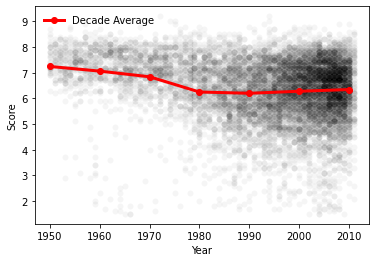

In [85]:
#mean score for all movies in each decade
decade_mean = data.groupby(decade).score.mean()
decade_mean.name = 'Decade Mean'
print(decade_mean)

plt.plot(decade_mean.index, decade_mean.values, 'o-',
        color='r', lw=3, label='Decade Average')
plt.scatter(data.year, data.score, alpha=.04, lw=0, color='k')
plt.xlabel("Year")
plt.ylabel("Score")
plt.legend(frameon=False)


We can go one further, and compute the scatter in each year as well

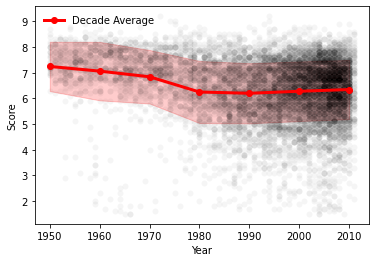

In [87]:
grouped_scores = data.groupby(decade).score

mean = grouped_scores.mean()
std = grouped_scores.std()

plt.plot(decade_mean.index, decade_mean.values, 'o-',
        color='r', lw=3, label='Decade Average')
plt.fill_between(decade_mean.index, (decade_mean + std).values,
                 (decade_mean - std).values, color='r', alpha=.2)
plt.scatter(data.year, data.score, alpha=.04, lw=0, color='k')
plt.xlabel("Year")
plt.ylabel("Score")
plt.legend(frameon=False)

You can also iterate over a GroupBy object. Each iteration yields two variables: one of the distinct values of the group key, and the subset of the dataframe where the key equals that value. To find the most popular movie each year:


In [89]:
for year, subset in data.groupby('year'):
    print(year, subset[subset.score == subset.score.max()].title.values)

1950 ['Sunset Blvd.']
1951 ['Strangers on a Train']
1952 ["Singin' in the Rain"]
1953 ['The Wages of Fear' 'Tokyo Story']
1954 ['Seven Samurai']
1955 ['Diabolique']
1956 ['The Killing']
1957 ['12 Angry Men']
1958 ['Vertigo']
1959 ['North by Northwest']
1960 ['Psycho']
1961 ['Yojimbo']
1962 ['To Kill a Mockingbird' 'Lawrence of Arabia']
1963 ['The Great Escape' 'High and Low']
1964 ['Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb']
1965 ['For a Few Dollars More']
1966 ['The Good, the Bad and the Ugly']
1967 ['Cool Hand Luke']
1968 ['Once Upon a Time in the West']
1969 ['Butch Cassidy and the Sundance Kid' 'Army of Shadows']
1970 ['Patton' 'The Conformist' 'Le Cercle Rouge']
1971 ['A Clockwork Orange']
1972 ['The Godfather']
1973 ['The Sting' 'Scenes from a Marriage']
1974 ['The Godfather: Part II']
1975 ['Outrageous Class']
1976 ['Tosun Pasa']
1977 ['Star Wars: Episode IV - A New Hope']
1978 ['The Girl with the Red Scarf']
1979 ['Apocalypse Now']
1980 ['Star Wars: 

### Small multiples

Let's split up the movies by genre, and look at how their release year/runtime/IMDB score vary.
The distribution for all movies is shown as a grey background.

This isn't a standard groupby, so we can't use the `groupby` method here. A manual loop is needed

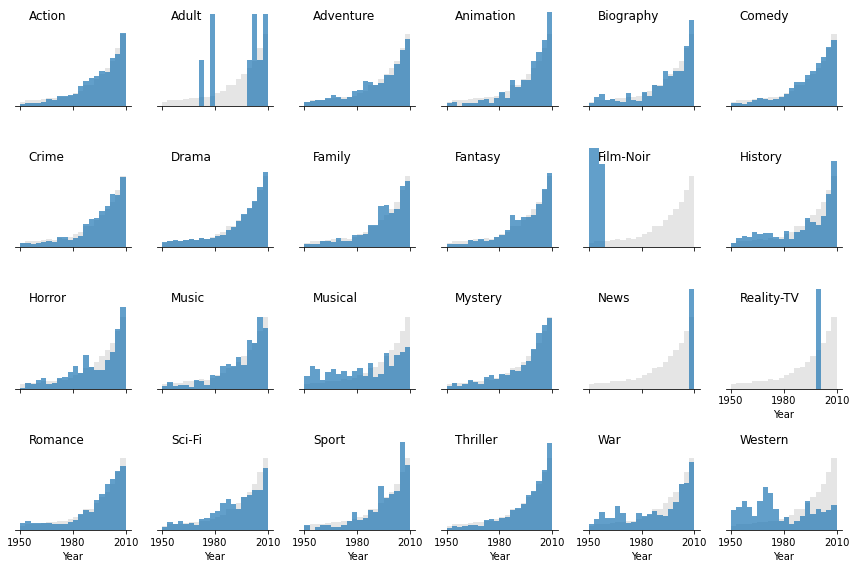

In [132]:
#create a 4x6 grid of plots.
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), 
                         tight_layout=True)

bins = np.arange(1950, 2013, 3)
counter = 0
for ax, genre in zip(axes.ravel(), genre_cols):
    ax.hist(data[data[genre] == 1].year, 
            bins=bins, histtype='stepfilled', density=True, alpha=.7, ec='none')
    ax.hist(data.year, bins=bins, histtype='stepfilled', ec='None', density=True, zorder=0, color='#cccccc', alpha=0.5)
    
    ax.annotate(genre[6:], xy=(1955, 0.07), fontsize=12)
    ax.xaxis.set_ticks(np.arange(1950, 2013, 30))
    ax.set_yticks([])
    ax.set_ylim((0, 0.08))   
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    counter += 1
    if counter >= 18:
        ax.set_xlabel('Year')
    else:
        ax.set_xticklabels([])
fig.tight_layout()

Some subtler patterns here:

1. Westerns and Musicals have a more level distribution
2. Film Noir movies were much more popular in the 50s and 60s

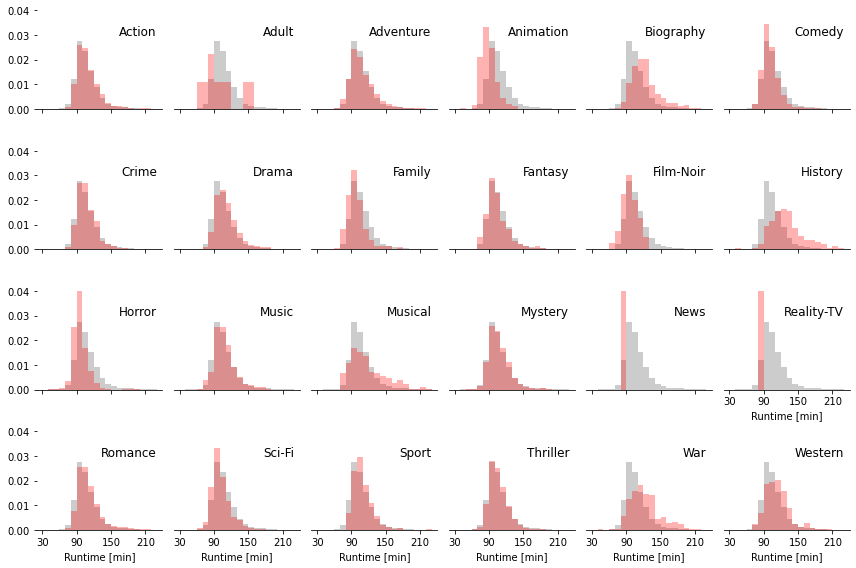

In [139]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), tight_layout=True)

bins = np.arange(30, 240, 10)
counter = 0
for ax, genre in zip(axes.ravel(), genre_cols):
    ax.hist(data[data[genre] == 1].runtime, 
            bins=bins, histtype='stepfilled', color='r', ec='none', alpha=.3, density=True)
               
    ax.hist(data.runtime, bins=bins, density=True,
            histtype='stepfilled', ec='none', color='#cccccc',
            zorder=0)
    
    ax.set_xticks(np.arange(30, 240, 60))
    if counter not in [0, 6, 12, 18]:
        ax.set_yticks([])
    ax.annotate(genre[6:], xy=(230, .03), ha='right', fontsize=12)
    ax.set_ylim((0, 0.04))   
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    counter += 1
    if counter >= 18:
        ax.set_xlabel("Runtime [min]")
    else:
        ax.set_xticklabels([])
fig.tight_layout()

1. Biographies and history movies are longer
1. Animated movies are shorter
1. Film-Noir movies have the same mean, but are more conentrated around a 100 minute runtime
1. Musicals have the same mean, but greater dispersion in runtimes

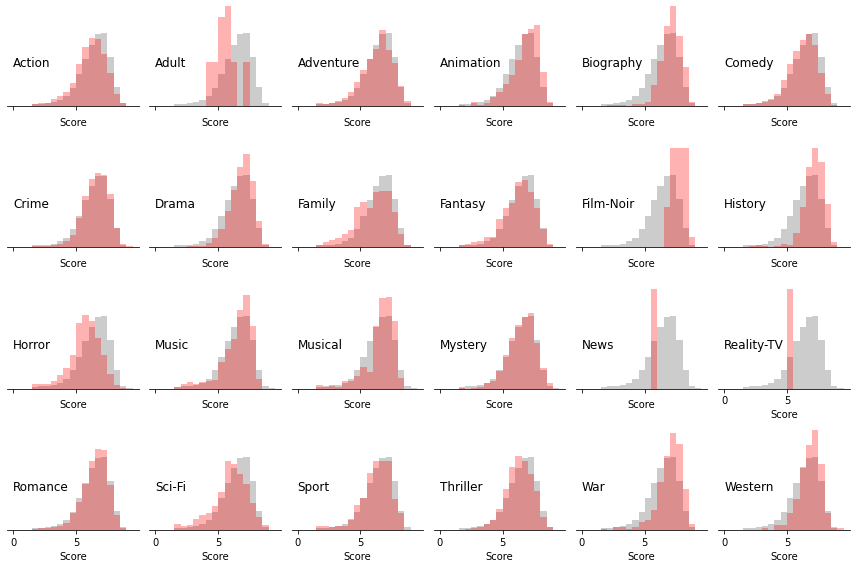

In [140]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), tight_layout=True)

bins = np.arange(0, 10, .5)
counter = 0
for ax, genre in zip(axes.ravel(), genre_cols):
    ax.hist(data[data[genre] == 1].score, 
            bins=bins, histtype='stepfilled', color='r', ec='none', alpha=.3, density=True)
               
    ax.hist(data.score, bins=bins, density=True,
            histtype='stepfilled', ec='none', color='#cccccc',
            zorder=0)
    
    ax.set_yticks([])
    ax.set_xlabel("Score")
    ax.set_ylim(0, .5)
    ax.annotate(genre[6:], xy=(0, .2), ha='left', fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    counter += 1
    if counter >= 18:
        ax.set_xlabel("Score")
    else:
        ax.set_xticklabels([])
fig.tight_layout()

1. Film-noirs, histories, and biographies have higher ratings (a selection effect?)
1. Horror movies and adult films have lower ratings